#**Spotify API**
My aim in this notebook is try to collect some real time data using spotify API and do a little analysis from the collected data.

##**Library**
First thing first, import the library that we need to support our project

Spotipy is a lightweight Python library for the Spotify Web API.

In [1]:
!pip install spotipy

In [2]:
import os
import sys
import json
import numpy as np
import pandas as pd
import spotipy
import spotipy.util as util
import webbrowser

from json.decoder import JSONDecodeError
from spotipy.oauth2 import SpotifyClientCredentials
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

##**Collect Spotify Data Using Its API**

The data that we collected will be use for the analysis real time data.

In [0]:
SPOTIPY_CLIENT_ID = "94e5ebe1afc748e1ac73754e096a0493"
SPOTIPY_CLIENT_SECRET = "fee58b88901146bd928841421208d873"
SPOTIPY_REDIRECT_URI = "https://github.com/arianrasyidd/redirect"

In [0]:
client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #Spotify object to access API

In [0]:
scope = 'user-read-private'
username = 'arianrasyid'

try :
    token = util.prompt_for_user_token(username, client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET, redirect_uri=SPOTIPY_REDIRECT_URI)
except:
    os.remove(f".cache-{username}")
    token = util.prompt_for_user_token(username, client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET, redirect_uri=SPOTIPY_REDIRECT_URI)

In [0]:
 sp_auth = spotipy.Spotify(auth = token)
user = sp_auth.current_user()
# print(json.dumps(user, sort_keys=True, indent=4))

###**Analyze by the Playlist**

####Get Playlist

In [0]:
#Indonesia Top 50 Playlist
playlist_id = '0N5hxKlqFl6z2gVUywrdcA'

####Get all track from playlist

In [0]:
def get_playlist_tracks(username,playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [0]:
playlist = get_playlist_tracks(username, playlist_id)
# print(json.dumps(playlist, sort_keys=True, indent=4))

####Get Track's name

In [0]:
def get_playlist_names(playlist):
    names = []
    for _track in playlist: 
        names.append(_track['track']['name'])
    return names

In [0]:
track_names =  get_playlist_names(playlist)
# print(json.dumps(track_names, sort_keys=True, indent=4))

In [0]:
def get_playlist_popularity(playlist):
    popularities = []
    for _track in playlist: 
        popularities.append(_track['track']['popularity'])
    return popularities

In [0]:
popularities = get_playlist_popularity(playlist)
# print(json.dumps(popularities, sort_keys=True, indent=4))

In [0]:
def get_playlist_duration(playlist): 
    durations = []
    for _track in playlist:
        durations.append(_track['track']['duration_ms'])
    return durations

In [0]:
durations = get_playlist_duration(playlist)
# print(json.dumps(durations, sort_keys=True, indent=4))

In [0]:
def get_playlist_release(playlist): 
    releases = []
    for _track in playlist:
        releases.append(_track['track']['album']['release_date'])
    return releases

In [0]:
releases = get_playlist_release(playlist)
# print(json.dumps(releases, sort_keys=True, indent=4))

In [0]:
def get_artist(playlist):
    artists = []
    for _track in playlist:
        _artists = []
        for _artist in _track['track']['artists']: 
            _artists.append(_artist['name'])
        artists.append(_artists)
    
    return artists

In [0]:
artists = get_artist(playlist)
# print(json.dumps(artists, sort_keys=True, indent=4))

####Get all audio feature for each track

#####Get track's URI

In [0]:
uris = set()
for track in playlist:
    uris.add(track['track']['uri'])

### Get Track's audio feature
Described by [Spotify API Documentation](https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/) there are several keys that describe songs, included in data collected, called audio feature.

**acousticness** : A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

**analysis_url** : An HTTP URL to access the full audio analysis of this track. An access token is required to access this data.

**danceability** : Danceability describes how suitable a track is for dancing based on a  combination of musical elements including tempo, rhythm stability, beat  strength, and overall regularity. A value of 0.0 is least danceable and  1.0 is most danceable.

**duration_ms** : The duration of the track in milliseconds.

**energy** : Energy is a measure from 0.0 to 1.0 and represents a perceptual measure  of intensity and activity. Typically, energetic tracks feel fast, loud,  and noisy. For example, death metal has high energy, while a Bach  prelude scores low on the scale. Perceptual features contributing to  this attribute include dynamic range, perceived loudness, timbre, onset  rate, and general entropy.

**id** : The Spotify ID for the track.

**instrumentalness** : Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are  treated as instrumental in this context. Rap or spoken word tracks are  clearly “vocal”. The closer the instrumentalness value is to 1.0, the  greater likelihood the track contains no vocal content. Values above 0.5  are intended to represent instrumental tracks, but confidence is higher  as the value approaches 1.0.

**key** : The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.

**liveness** : Detects the presence of an audience in the recording. Higher liveness  values represent an increased probability that the track was performed  live. A value above 0.8 provides strong likelihood that the track is  live.

**loudness** : The overall loudness of a track in decibels (dB). Loudness values are  averaged across the entire track and are useful for comparing relative  loudness of tracks. Loudness is the quality of a sound that is the  primary psychological correlate of physical strength (amplitude). Values  typical range between -60 and 0 db.

**mode** : Mode indicates the modality (major or minor) of a track, the type of  scale from which its melodic content is derived. Major is represented by  1 and minor is 0.

**speechiness** : Speechiness detects the presence of spoken words in a track. The more  exclusively speech-like the recording (e.g. talk show, audio book,  poetry), the closer to 1.0 the attribute value. Values above 0.66  describe tracks that are probably made entirely of spoken words. Values  between 0.33 and 0.66 describe tracks that may contain both music and  speech, either in sections or layered, including such cases as rap  music. Values below 0.33 most likely represent music and other  non-speech-like tracks.

**tempo** : The overall estimated tempo of a track in beats per minute (BPM). In  musical terminology, tempo is the speed or pace of a given piece and  derives directly from the average beat duration.

**time_signature** : An estimated overall time signature of a track. The time signature  (meter) is a notational convention to specify how many beats are in each  bar (or measure).

**track_href** : A link to the Web API endpoint providing full details of the track.

**type** : The object type: “audio_features”

**uri** : The Spotify URI for the track.

**valence** : A measure from 0.0 to 1.0 describing the musical positiveness conveyed  by a track. Tracks with high valence sound more positive (e.g. happy,  cheerful, euphoric), while tracks with low valence sound more negative  (e.g. sad, depressed, angry).

#####Get Track's audio feature

In [21]:
af = []
for _track in tqdm(uris):
    af.append(sp_auth.audio_features(_track)[0])

100%|██████████| 44/44 [00:01<00:00, 24.37it/s]


In [22]:
audio_feature = pd.DataFrame(af)
audio_feature.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.795,0.178,0,-11.991,1,0.0574,0.60700,0.0,0.6230,0.608,93.982,audio_features,18uwL0vNUanqZH0ro2QcOP,spotify:track:18uwL0vNUanqZH0ro2QcOP,https://api.spotify.com/v1/tracks/18uwL0vNUanq...,https://api.spotify.com/v1/audio-analysis/18uw...,181613,4
1,0.400,0.795,10,-3.731,0,0.4610,0.11900,0.0,0.1590,0.702,190.097,audio_features,0Ryd8975WihbObpp5cPW1t,spotify:track:0Ryd8975WihbObpp5cPW1t,https://api.spotify.com/v1/tracks/0Ryd8975Wihb...,https://api.spotify.com/v1/audio-analysis/0Ryd...,186107,4
2,0.682,0.656,6,-4.670,1,0.0435,0.07370,0.0,0.3530,0.607,130.089,audio_features,0uUNN1nSoUx1A4fkDCWDQ7,spotify:track:0uUNN1nSoUx1A4fkDCWDQ7,https://api.spotify.com/v1/tracks/0uUNN1nSoUx1...,https://api.spotify.com/v1/audio-analysis/0uUN...,183027,4
3,0.294,0.505,3,-8.106,1,0.0420,0.12000,0.0,0.0977,0.357,85.332,audio_features,6wo37KVqFJhtuxPTpLCcfe,spotify:track:6wo37KVqFJhtuxPTpLCcfe,https://api.spotify.com/v1/tracks/6wo37KVqFJht...,https://api.spotify.com/v1/audio-analysis/6wo3...,209893,1
4,0.769,0.678,2,-5.604,1,0.0507,0.00838,0.0,0.0596,0.706,85.025,audio_features,29fRTIKsJhLUJoldM89GZS,spotify:track:29fRTIKsJhLUJoldM89GZS,https://api.spotify.com/v1/tracks/29fRTIKsJhLU...,https://api.spotify.com/v1/audio-analysis/29fR...,171387,4


In [0]:
def get_playlist_data(username, playlist_id):
    playlist = get_playlist_tracks(username, playlist_id)
    features = [] 
    for track in tqdm(playlist):
        uri = track['track']['uri'] 
        af = sp_auth.audio_features(uri)[0]
        track_name = track['track']['name']
        popularity = track['track']['popularity']
        duration = track['track']['duration_ms']
        release_date = track['track']['album']['release_date']
        artists = []
        for _artist in track['track']['artists']: 
            artists.append(_artist['name'])
        af.update({'name':track_name, 'popularity':popularity, 'duration':duration, 'release_date':release_date, 'artists':artists})
        features.append(af)
    
    return pd.DataFrame(data=features)

In [24]:
features = get_playlist_data(username, playlist_id)

100%|██████████| 44/44 [00:01<00:00, 24.31it/s]


##**Exploratory Data Analysis**

In [25]:
features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,name,popularity,duration,release_date,artists
0,0.759,0.540,9,-6.039,0,0.0287,0.03700,0.000000,0.0945,0.750,116.947,audio_features,0TK2YIli7K1leLovkQiNik,spotify:track:0TK2YIli7K1leLovkQiNik,https://api.spotify.com/v1/tracks/0TK2YIli7K1l...,https://api.spotify.com/v1/audio-analysis/0TK2...,190960,4,Señorita,90,190960,2019-06-21,"[Shawn Mendes, Camila Cabello]"
1,0.648,0.382,6,-7.850,1,0.0396,0.91100,0.000000,0.3930,0.408,90.099,audio_features,5DuSzOxHDi1qZycpzIWyhO,spotify:track:5DuSzOxHDi1qZycpzIWyhO,https://api.spotify.com/v1/tracks/5DuSzOxHDi1q...,https://api.spotify.com/v1/audio-analysis/5DuS...,209734,4,I Love You 3000,10,209734,2019-06-03,[Stephanie Poetri]
2,0.756,0.648,0,-5.287,1,0.0731,0.11800,0.000000,0.5150,0.657,80.979,audio_features,2ZDpSQfBdgkooeXw6oj3Uz,spotify:track:2ZDpSQfBdgkooeXw6oj3Uz,https://api.spotify.com/v1/tracks/2ZDpSQfBdgko...,https://api.spotify.com/v1/audio-analysis/2ZDp...,166146,4,100 Degrees,73,166145,2019-07-26,[Rich Brian]
3,0.432,0.556,9,-7.415,0,0.0282,0.00249,0.000162,0.2320,0.168,139.756,audio_features,4ZGXS9ZynTju8WaxHLPcLW,spotify:track:4ZGXS9ZynTju8WaxHLPcLW,https://api.spotify.com/v1/tracks/4ZGXS9ZynTju...,https://api.spotify.com/v1/audio-analysis/4ZGX...,257143,4,it is you,30,257142,2019-08-13,[Rossy]
4,0.700,0.208,0,-11.410,1,0.0724,0.94600,0.923000,0.0854,0.112,90.016,audio_features,2dUp54GW8AvsgfIkWUUcaa,spotify:track:2dUp54GW8AvsgfIkWUUcaa,https://api.spotify.com/v1/tracks/2dUp54GW8Avs...,https://api.spotify.com/v1/audio-analysis/2dUp...,197333,4,outside the window,35,197333,2019-08-14,[Lofi Radiance]


In [0]:
features.to_csv('Spotify_api.csv')

In [27]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 23 columns):
danceability        44 non-null float64
energy              44 non-null float64
key                 44 non-null int64
loudness            44 non-null float64
mode                44 non-null int64
speechiness         44 non-null float64
acousticness        44 non-null float64
instrumentalness    44 non-null float64
liveness            44 non-null float64
valence             44 non-null float64
tempo               44 non-null float64
type                44 non-null object
id                  44 non-null object
uri                 44 non-null object
track_href          44 non-null object
analysis_url        44 non-null object
duration_ms         44 non-null int64
time_signature      44 non-null int64
name                44 non-null object
popularity          44 non-null int64
duration            44 non-null int64
release_date        44 non-null object
artists             44 non-null obje

In [28]:
features.select_dtypes(include='object').head()

,type,id,uri,track_href,analysis_url,name,release_date,artists
0,audio_features,0TK2YIli7K1leLovkQiNik,spotify:track:0TK2YIli7K1leLovkQiNik,https://api.spotify.com/v1/tracks/0TK2YIli7K1l...,https://api.spotify.com/v1/audio-analysis/0TK2...,Señorita,2019-06-21,"[Shawn Mendes, Camila Cabello]"
1,audio_features,5DuSzOxHDi1qZycpzIWyhO,spotify:track:5DuSzOxHDi1qZycpzIWyhO,https://api.spotify.com/v1/tracks/5DuSzOxHDi1q...,https://api.spotify.com/v1/audio-analysis/5DuS...,I Love You 3000,2019-06-03,[Stephanie Poetri]
2,audio_features,2ZDpSQfBdgkooeXw6oj3Uz,spotify:track:2ZDpSQfBdgkooeXw6oj3Uz,https://api.spotify.com/v1/tracks/2ZDpSQfBdgko...,https://api.spotify.com/v1/audio-analysis/2ZDp...,100 Degrees,2019-07-26,[Rich Brian]
3,audio_features,4ZGXS9ZynTju8WaxHLPcLW,spotify:track:4ZGXS9ZynTju8WaxHLPcLW,https://api.spotify.com/v1/tracks/4ZGXS9ZynTju...,https://api.spotify.com/v1/audio-analysis/4ZGX...,it is you,2019-08-13,[Rossy]
4,audio_features,2dUp54GW8AvsgfIkWUUcaa,spotify:track:2dUp54GW8AvsgfIkWUUcaa,https://api.spotify.com/v1/tracks/2dUp54GW8Avs...,https://api.spotify.com/v1/audio-analysis/2dUp...,outside the window,2019-08-14,[Lofi Radiance]


In [29]:
clean_af = features.drop(columns=['analysis_url', 'id', 'track_href', 'uri', 'type'])
clean_af.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,name,popularity,duration,release_date,artists
0,0.759,0.540,9,-6.039,0,0.0287,0.03700,0.000000,0.0945,0.750,116.947,190960,4,Señorita,90,190960,2019-06-21,"[Shawn Mendes, Camila Cabello]"
1,0.648,0.382,6,-7.850,1,0.0396,0.91100,0.000000,0.3930,0.408,90.099,209734,4,I Love You 3000,10,209734,2019-06-03,[Stephanie Poetri]
2,0.756,0.648,0,-5.287,1,0.0731,0.11800,0.000000,0.5150,0.657,80.979,166146,4,100 Degrees,73,166145,2019-07-26,[Rich Brian]
3,0.432,0.556,9,-7.415,0,0.0282,0.00249,0.000162,0.2320,0.168,139.756,257143,4,it is you,30,257142,2019-08-13,[Rossy]
4,0.700,0.208,0,-11.410,1,0.0724,0.94600,0.923000,0.0854,0.112,90.016,197333,4,outside the window,35,197333,2019-08-14,[Lofi Radiance]


In [30]:
clean_af.duration == clean_af.duration_ms

0      True
1      True
2     False
3     False
4      True
5     False
6      True
7     False
8     False
9      True
10    False
11     True
12    False
13    False
14    False
15     True
16    False
17    False
18    False
19     True
20     True
21    False
22     True
23    False
24     True
25     True
26    False
27     True
28     True
29     True
30    False
31     True
32    False
33     True
34    False
35    False
36    False
37    False
38     True
39     True
40     True
41     True
42     True
43    False
dtype: bool

In [31]:
abs(clean_af.duration - clean_af.duration_ms).mean()

0.5

In [32]:
clean_af.drop(columns=['duration_ms'], inplace=True)
clean_af

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,name,popularity,duration,release_date,artists
0,0.759,0.540,9,-6.039,0,0.0287,0.03700,0.000000,0.0945,0.750,116.947,4,Señorita,90,190960,2019-06-21,"[Shawn Mendes, Camila Cabello]"
1,0.648,0.382,6,-7.850,1,0.0396,0.91100,0.000000,0.3930,0.408,90.099,4,I Love You 3000,10,209734,2019-06-03,[Stephanie Poetri]
2,0.756,0.648,0,-5.287,1,0.0731,0.11800,0.000000,0.5150,0.657,80.979,4,100 Degrees,73,166145,2019-07-26,[Rich Brian]
3,0.432,0.556,9,-7.415,0,0.0282,0.00249,0.000162,0.2320,0.168,139.756,4,it is you,30,257142,2019-08-13,[Rossy]
4,0.700,0.208,0,-11.410,1,0.0724,0.94600,0.923000,0.0854,0.112,90.016,4,outside the window,35,197333,2019-08-14,[Lofi Radiance]
5,0.798,0.675,6,-5.041,1,0.0442,0.09120,0.000000,0.0894,0.842,101.956,4,I Don't Care (with Justin Bieber),87,219946,2019-05-10,"[Ed Sheeran, Justin Bieber]"
6,0.294,0.146,7,-13.090,1,0.0336,0.93300,0.000044,0.1300,0.299,177.658,3,Hanya Rindu,69,251056,2019-04-26,[Andmesh]
7,0.435,0.200,9,-12.481,1,0.0365,0.89100,0.000000,0.1030,0.244,136.054,4,Tolong,73,250322,2018-10-30,[Budi Doremi]
8,0.590,0.263,9,-10.006,1,0.0283,0.72700,0.000000,0.1170,0.325,135.927,4,Cinta Luar Biasa,69,255624,2018-11-02,[Andmesh]
9,0.302,0.414,2,-8.160,1,0.0319,0.05750,0.000000,0.0861,0.105,110.508,4,"A Whole New World (End Title) - From ""Aladdin""",75,242956,2019-05-09,"[ZAYN, Zhavia Ward]"


In [33]:
clean_af.select_dtypes(exclude='object').describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity,duration
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,0.596705,0.507091,5.068182,-7.416614,0.704545,0.074300,0.398586,0.029227,0.167302,0.413477,117.710818,3.931818,65.318182,214124.590909
std,0.149687,0.179346,3.656137,2.622514,0.461522,0.086074,0.291685,0.146612,0.122303,0.211320,28.429614,0.501056,21.415896,36057.836175
min,0.294000,0.146000,0.000000,-13.090000,0.000000,0.026700,0.002490,0.000000,0.059600,0.105000,70.142000,1.000000,9.000000,156346.000000
25%,0.478500,0.380000,1.750000,-8.260500,0.000000,0.032200,0.119750,0.000000,0.096900,0.241000,94.757500,4.000000,59.750000,190920.000000
50%,0.623500,0.514000,5.000000,-7.281500,1.000000,0.044050,0.427000,0.000000,0.117500,0.351000,117.424000,4.000000,72.500000,204942.000000
75%,0.724250,0.648500,9.000000,-5.056750,1.000000,0.070975,0.600250,0.000000,0.189750,0.562750,135.273000,4.000000,81.000000,234427.750000
max,0.806000,0.862000,11.000000,-3.731000,1.000000,0.461000,0.946000,0.923000,0.623000,0.864000,190.097000,5.000000,90.000000,313670.000000


These equation may help you summarize the process of normalied value (denoted by $z$)

$$ z = \frac{x - min(x)}{max(x) - min(x)}$$

$$ x = z * (max(x) - min(x))  + min(x)$$

In [0]:
class SpNormalizer():
    def __init__(self, feature):
        self.min_val = feature.min()
        self.max_val = feature.max()
        self.mean_val = feature.mean()
        
        self.norm_cols = ['duration', 'key','loudness', 'popularity', 'tempo', 'time_signature']
        
        self.min_val[['duration', 'key','loudness', 'popularity', 'tempo', 'time_signature']] = [0,0,-60,0,0,3]
        self.max_val[['key','loudness', 'popularity', 'time_signature']] = [12,0,100,7]
        
    def scale(self, feature):
        _feature = feature.copy()
        for col in self.norm_cols:
            _feature[col] = _feature[col].apply(lambda x : (x - self.min_val[col])/(self.max_val[col] - self.min_val[col]))
        return _feature

    
    def descale(self, feature):
        _feature = feature.copy()
        
        for col in self.norm_cols:
            _feature[col] = _feature[col].apply(lambda x : x *(self.max_val[col] - self.min_val[col]) + self.min_val[col])
        return _feature

In [0]:
a = clean_af.copy()
spnorm = SpNormalizer(a)
a2 = spnorm.scale(a)
a3 = spnorm.descale(a2)

In [36]:
a2.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,name,popularity,duration,release_date,artists
0,0.759,0.540,0.75,0.899350,0,0.0287,0.03700,0.000000,0.0945,0.750,0.615196,0.25,Señorita,0.90,0.608793,2019-06-21,"[Shawn Mendes, Camila Cabello]"
1,0.648,0.382,0.50,0.869167,1,0.0396,0.91100,0.000000,0.3930,0.408,0.473963,0.25,I Love You 3000,0.10,0.668645,2019-06-03,[Stephanie Poetri]
2,0.756,0.648,0.00,0.911883,1,0.0731,0.11800,0.000000,0.5150,0.657,0.425988,0.25,100 Degrees,0.73,0.529681,2019-07-26,[Rich Brian]
3,0.432,0.556,0.75,0.876417,0,0.0282,0.00249,0.000162,0.2320,0.168,0.735183,0.25,it is you,0.30,0.819785,2019-08-13,[Rossy]
4,0.700,0.208,0.00,0.809833,1,0.0724,0.94600,0.923000,0.0854,0.112,0.473527,0.25,outside the window,0.35,0.629110,2019-08-14,[Lofi Radiance]


In [37]:
a3.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,name,popularity,duration,release_date,artists
0,0.759,0.540,9.0,-6.039,0,0.0287,0.03700,0.000000,0.0945,0.750,116.947,4.0,Señorita,90.0,190960.0,2019-06-21,"[Shawn Mendes, Camila Cabello]"
1,0.648,0.382,6.0,-7.850,1,0.0396,0.91100,0.000000,0.3930,0.408,90.099,4.0,I Love You 3000,10.0,209734.0,2019-06-03,[Stephanie Poetri]
2,0.756,0.648,0.0,-5.287,1,0.0731,0.11800,0.000000,0.5150,0.657,80.979,4.0,100 Degrees,73.0,166145.0,2019-07-26,[Rich Brian]
3,0.432,0.556,9.0,-7.415,0,0.0282,0.00249,0.000162,0.2320,0.168,139.756,4.0,it is you,30.0,257142.0,2019-08-13,[Rossy]
4,0.700,0.208,0.0,-11.410,1,0.0724,0.94600,0.923000,0.0854,0.112,90.016,4.0,outside the window,35.0,197333.0,2019-08-14,[Lofi Radiance]


In [38]:
a.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,name,popularity,duration,release_date,artists
0,0.759,0.540,9,-6.039,0,0.0287,0.03700,0.000000,0.0945,0.750,116.947,4,Señorita,90,190960,2019-06-21,"[Shawn Mendes, Camila Cabello]"
1,0.648,0.382,6,-7.850,1,0.0396,0.91100,0.000000,0.3930,0.408,90.099,4,I Love You 3000,10,209734,2019-06-03,[Stephanie Poetri]
2,0.756,0.648,0,-5.287,1,0.0731,0.11800,0.000000,0.5150,0.657,80.979,4,100 Degrees,73,166145,2019-07-26,[Rich Brian]
3,0.432,0.556,9,-7.415,0,0.0282,0.00249,0.000162,0.2320,0.168,139.756,4,it is you,30,257142,2019-08-13,[Rossy]
4,0.700,0.208,0,-11.410,1,0.0724,0.94600,0.923000,0.0854,0.112,90.016,4,outside the window,35,197333,2019-08-14,[Lofi Radiance]


In [39]:
(a == a3).head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,name,popularity,duration,release_date,artists
0,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True
3,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True


###Artist with most appearance

In [40]:
clean_af['artists'].head()

0    [Shawn Mendes, Camila Cabello]
1                [Stephanie Poetri]
2                      [Rich Brian]
3                           [Rossy]
4                   [Lofi Radiance]
Name: artists, dtype: object

In [41]:
_artist = []
for artists in clean_af['artists']: 
    for i in artists:
        _artist.append(i)
_artist = pd.Series(_artist)
artist_count = _artist.value_counts()
artist_count.head()

Ariana Grande    3
Marion Jola      2
Alan Walker      2
Halsey           2
Justin Bieber    2
dtype: int64

In [42]:
artist_count.describe()

count    59.000000
mean      1.169492
std       0.421514
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       3.000000
dtype: float64

In [0]:
playlist_id = '0N5hxKlqFl6z2gVUywrdcA'
playlist_us = '37i9dQZEVXbLRQDuF5jeBp'

In [44]:
features_id = get_playlist_data(username, playlist_id)

100%|██████████| 44/44 [00:01<00:00, 24.31it/s]


In [45]:
features_id.shape

(44, 23)

In [46]:
features_us = get_playlist_data(username, playlist_us)

 12%|█▏        | 6/50 [00:00<00:01, 24.33it/s]

retrying ...2secs


100%|██████████| 50/50 [00:05<00:00, 22.65it/s]


In [47]:
features_us.shape

(50, 23)

In [0]:
features_id['location'] = ['Indonesia']*features_id.shape[0]
features_us['location'] = ['America']*features_us.shape[0]

In [49]:
features_c = features_id.append(features_us).reset_index(drop=True)
features_c.tail()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,name,popularity,duration,release_date,artists,location
89,0.380,0.219,4,-13.273,0,0.0358,0.9170,0.010400,0.0827,0.0517,73.537,audio_features,73SpzrcaHk0RQPFP73vqVR,spotify:track:73SpzrcaHk0RQPFP73vqVR,https://api.spotify.com/v1/tracks/73SpzrcaHk0R...,https://api.spotify.com/v1/audio-analysis/73Sp...,242265,4,No Time To Die,93,242265,2020-02-13,[Billie Eilish],America
90,0.591,0.585,2,-6.350,1,0.0277,0.1430,0.000000,0.1090,0.3240,110.940,audio_features,7lidXGPXPYLNThITAOTlkK,spotify:track:7lidXGPXPYLNThITAOTlkK,https://api.spotify.com/v1/tracks/7lidXGPXPYLN...,https://api.spotify.com/v1/audio-analysis/7lid...,205473,4,You should be sad,91,205473,2020-01-17,[Halsey],America
91,0.755,0.522,2,-4.368,1,0.0575,0.5330,0.000000,0.0685,0.9250,89.960,audio_features,0RiRZpuVRbi7oqRdSMwhQY,spotify:track:0RiRZpuVRbi7oqRdSMwhQY,https://api.spotify.com/v1/tracks/0RiRZpuVRbi7...,https://api.spotify.com/v1/audio-analysis/0RiR...,157560,4,Sunflower - Spider-Man: Into the Spider-Verse,84,157560,2019-09-06,"[Post Malone, Swae Lee]",America
92,0.816,0.582,8,-4.141,1,0.3410,0.0794,0.000006,0.0916,0.5420,160.004,audio_features,2FvD20Z8aoWIePi7PoN8sG,spotify:track:2FvD20Z8aoWIePi7PoN8sG,https://api.spotify.com/v1/tracks/2FvD20Z8aoWI...,https://api.spotify.com/v1/audio-analysis/2FvD...,136366,4,TOES (feat. Lil Baby & Moneybagg Yo),87,136366,2019-09-27,"[DaBaby, Lil Baby, Moneybagg Yo]",America
93,0.820,0.635,5,-5.749,0,0.0772,0.4090,0.000000,0.2440,0.5280,101.024,audio_features,0fgsKar6uBO08vzHXkTjWi,spotify:track:0fgsKar6uBO08vzHXkTjWi,https://api.spotify.com/v1/tracks/0fgsKar6uBO0...,https://api.spotify.com/v1/audio-analysis/0fgs...,258280,4,P FKN R,70,258280,2020-02-29,"[Bad Bunny, Kendo Kaponi, Arcangel]",America


In [0]:
# drop unnecessary feature 
features_c.drop(columns=['analysis_url', 'id', 'track_href', 'uri', 'type', 'duration_ms'], inplace=True)

In [0]:
# fit and transform to rescale features value 
spnorm = SpNormalizer(features_c)
features_cn = spnorm.scale(features_c)

In [52]:
features_c.select_dtypes(exclude='object').mean()

danceability             0.683606
energy                   0.577915
key                      5.478723
loudness                -6.622787
mode                     0.585106
speechiness              0.109796
acousticness             0.282238
instrumentalness         0.020922
liveness                 0.161779
valence                  0.483720
tempo                  119.077883
time_signature           3.978723
popularity              74.148936
duration            205558.936170
dtype: float64

In [53]:
features_cn.select_dtypes(exclude='object').mean()

danceability        0.683606
energy              0.577915
key                 0.456560
loudness            0.889620
mode                0.585106
speechiness         0.109796
acousticness        0.282238
instrumentalness    0.020922
liveness            0.161779
valence             0.483720
tempo               0.626406
time_signature      0.244681
popularity          0.741489
duration            0.567927
dtype: float64

In [0]:
features_id = features_cn [features_cn['location'] == 'Indonesia']
features_us = features_cn [features_cn['location'] == 'America']

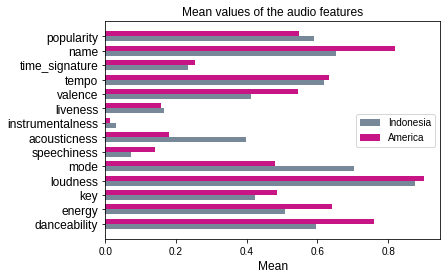

In [55]:
N = len(features_cn.mean())
ind = np.arange(N) 

width = 0.35  
plt.barh(ind, features_id.mean() , width, label='Indonesia', color = 'lightslategray')
plt.barh(ind + width, features_us.mean(), width, label='America', color = 'mediumvioletred')

plt.xlabel('Mean', fontsize = 12)
plt.title('Mean values of the audio features')
plt.yticks(ind + width / 2, (list(features_us)[:]), fontsize = 12)
plt.legend(loc='best')
plt.rcParams['figure.figsize'] =(8,8)
style.use("seaborn")
plt.savefig('aduio_feature_bar.png')
plt.show()

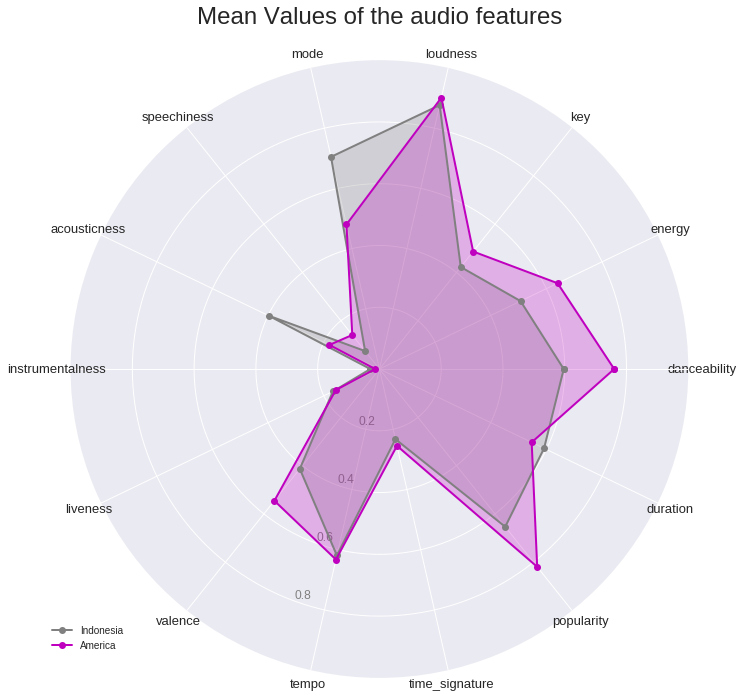

In [56]:
labels= list(features_id.select_dtypes(exclude='object').columns)
stats= features_id.mean().tolist()
stats2 = features_us.mean().tolist()

angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)

stats = np.concatenate((stats,[stats[0]]))
stats2 = np.concatenate((stats2,[stats2[0]])) 
angles = np.concatenate((angles,[angles[0]]))

fig = plt.figure(figsize = (25,25))

ax = fig.add_subplot(221, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2, label = "Indonesia", color= 'gray')
ax.fill(angles, stats, alpha=0.25, facecolor='gray')
ax.set_thetagrids(angles * 180/np.pi, labels , fontsize = 13)

ax.set_rlabel_position(250)
plt.yticks([0.2 , 0.4 , 0.6 , 0.8  ], ["0.2",'0.4', "0.6", "0.8"], color="grey", size=12)
plt.ylim(0,1)

ax.plot(angles, stats2, 'o-', linewidth=2, label = "America", color = 'm')
ax.fill(angles, stats2, alpha=0.25, facecolor='m' )
ax.set_title('Mean Values of the audio features', size=24)
ax.grid(True)

plt.savefig('audio_feature_compare.png')
plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))